In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Load

In [6]:
X_trains = {}
X_tests = {}
y_trains = {}
y_tests = {}

loan = pd.read_csv('/kaggle/input/184702-tu-ml-ws-23-loan/loan-10k.lrn.csv')
tes = pd.read_csv('/kaggle/input/184702-tu-ml-ws-23-loan/loan-10k.tes.csv')
X = loan.drop('grade', axis='columns')
y = loan['grade']


X_trains['raw'], X_tests['raw'], y_trains['raw'], y_tests['raw'] = model_selection.train_test_split(X, y, test_size=0.2, random_state=25)

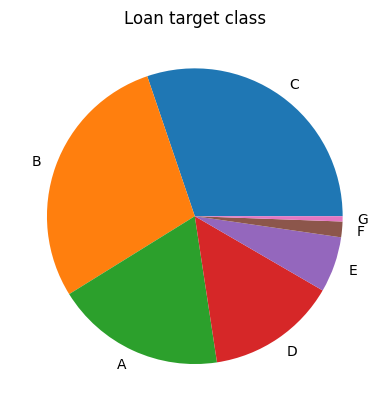

In [7]:
y_trains['raw'].value_counts().plot(kind='pie', ylabel='')
plt.title('Loan target class')
plt.savefig('loan-y.png')

# Pre-process

## Specify categorical columns

In [8]:
cols_cat = [ c for c in X_trains['raw'].columns if X_trains['raw'][c].dtype == 'O' ]
cols_ordinal_values = {
    'emp_length': ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years'],
    'pymnt_plan': ['n', 'y'],
    'hardship_flag': ['N', 'Y'],
    'debt_settlement_flag': ['N', 'Y']
}
cols_ordinal = list(cols_ordinal_values.keys())
cols_ordinal.append('term')
cols_nominal = list(set(cols_cat) - set(cols_ordinal))

# cat_values = { c: list(X_trains['raw'][c].unique()) for c in X_trains['raw'].columns if X_trains['raw'][c].dtype == 'O'}
cols_log = ['annual_inc', 'dti', 'delinq_2yrs', 'revol_bal', 'out_prncp', 'out_prncp_inv', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy', 'delinq_amnt', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit']

## One-hot all columns

In [9]:
# for X in [X_trains, X_tests]:
#     X['onehot'] = pd.get_dummies(X['raw'], columns = cols_cat)
temp = pd.get_dummies(pd.concat([X_trains['raw'], X_tests['raw'], tes],keys=[0, 1, 2]), columns=cols_cat)
X_trains['onehot'], X_tests['onehot'], X_sub = temp.xs(0), temp.xs(1), temp.xs(2)

## Label encode ordinal columns, convert Y/N columns to 1/0, one-hot encode the rest

In [10]:
for X in [X_trains, X_tests]:
    # Label encoding on ordinal attributes
    df = X['raw'].copy()
    enc = OrdinalEncoder(categories = [l for l in cols_ordinal_values.values() ])
    df[list(cols_ordinal_values.keys())] = enc.fit_transform(df[list(cols_ordinal_values.keys())])
    df[list(cols_ordinal_values.keys())] = df[list(cols_ordinal_values.keys())].astype('int32')
    df['term'] = df['term'].str.extract(r'(\d+)').astype('int32')

    X['onehot_label'] = df.copy()
    
temp = pd.get_dummies(pd.concat([X_trains['onehot_label'], X_tests['onehot_label']],keys=[0,1]), columns=cols_nominal)
X_trains['onehot_label'], X_tests['onehot_label']= temp.xs(0), temp.xs(1)

## Log transform

In [11]:
for X in [X_trains, X_tests]:
    df = X['raw'].copy()
    for c in X['raw']:
        if c in cols_log:
            df[c] = np.log(df[c] + 1)
    X['log'] = df.copy()

## Combine logged set with encoded sets

In [12]:
for X in [X_trains, X_tests]:
    X['onehot_log'] = X['onehot'].copy()
    X['onehot_log'][cols_log] = X['log'][cols_log]

    X['onehot_label_log'] = X['onehot_label'].copy()
    X['onehot_label_log'][cols_log] = X['log'][cols_log]

## Min-max scaling

In [13]:
trains_scaled = {}
tests_scaled = {}
for X, scaled in [(X_trains,trains_scaled), (X_tests,tests_scaled)]:
    for k, df in X.items():
        if 'minmax' in k or 'z' in k:
            continue
        name = 'minmax' if k == 'raw' else k + '_minmax'
        scaled[name] = df.copy()
        cols_num = list(scaled[name].select_dtypes(include='number'))
        scaled[name][cols_num] = MinMaxScaler().fit_transform(scaled[name][cols_num].to_numpy())

## Z-score standarisation

In [14]:
trains_z = {}
tests_z = {}
for X, z in [(X_trains,trains_z), (X_tests,tests_z)]:
    for k, df in X.items():
        if 'minmax' in k or 'z' in k:
            continue
        name = 'z' if k == 'raw' else k + '_z'
        z[name] = df.copy()
        cols_num = list(z[name].select_dtypes(include='number'))
        z[name][cols_num] = StandardScaler().fit_transform(z[name][cols_num].to_numpy())

In [16]:
# add scaled and standardised DFs to data set dicts
X_trains = dict(X_trains, **trains_scaled)
X_trains.update(trains_z)
X_tests = dict(X_tests, **tests_scaled)
X_tests.update(tests_z)
print(X_trains.keys())
print(X_tests.keys())

dict_keys(['raw', 'onehot', 'onehot_label', 'log', 'onehot_log', 'onehot_label_log', 'minmax', 'onehot_minmax', 'onehot_label_minmax', 'log_minmax', 'onehot_log_minmax', 'onehot_label_log_minmax', 'z', 'onehot_z', 'onehot_label_z', 'log_z', 'onehot_log_z', 'onehot_label_log_z'])
dict_keys(['raw', 'onehot', 'onehot_label', 'log', 'onehot_log', 'onehot_label_log', 'minmax', 'onehot_minmax', 'onehot_label_minmax', 'log_minmax', 'onehot_log_minmax', 'onehot_label_log_minmax', 'z', 'onehot_z', 'onehot_label_z', 'log_z', 'onehot_log_z', 'onehot_label_log_z'])


# Encode y

In [17]:
order = ['G', 'F', 'E', 'D', 'C', 'B', 'A']
for y in [y_trains, y_tests]:
    y['encoded'] = y['raw'].apply(lambda x: order.index(x))

# Train

## Classifier 1 - k-nearest neighbours

In [ ]:
gs_knn = {}
legend = []
results_knn = []
for preprocess, X_train in X_trains.items():
    # Skip pre-processed DFs with string (categorical) values
    if len(X_train.select_dtypes(include='object', exclude=['number', 'bool']).columns):
        continue
    
    X_test = X_tests[preprocess]
    y_train = y_trains['encoded']
    y_test = y_tests['encoded']
    print(f"KNN on {preprocess} set: ")
    # holdout
    knn = neighbors.KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_tests[preprocess])
    print(f"Original holdout training/test split - Accuracy: {knn.score(X_test,y_test)}" )

    # Cross validation
    scores = model_selection.cross_val_score(knn, X_train, y_train)
    print("CV fold accuracies:", scores)
    print("Accuracies: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))
    
    results_knn.append((preprocess, knn.score(X_test,y_test)))
    # grid search
    kvals=list(range(1,81, 10))
    p = [1, 2]
    knng=model_selection.GridSearchCV(
        estimator=knn,
        param_grid = {'n_neighbors': kvals, 'p': p}
    )
    knng.fit(X_train,y_train)
    gs = pd.DataFrame.from_dict(knng.cv_results_)
    gs_knn[preprocess] = gs
    
    print("Grid search best score: %0.3f, Best Estimator: %f" % (knng.best_score_,knng.best_estimator_.n_neighbors))
    knnresult = knng.predict(X_test)
    print("Score on y_test ",knng.score(X_test,y_test))
    results_knn.append((preprocess, knng.score(X_test,y_test)))
    print(metrics.confusion_matrix(y_test, knnresult))
    print('----')
results_knn = pd.DataFrame.from_records(results_knn, columns=['preprocess', 'test_accuracy'])
for t in ['onehot', 'label', 'log', 'minmax', 'z']:
    results_knn[t] = results_knn['preprocess'].str.contains(t)
results_knn.drop('preprocess', axis='columns', inplace=True)
print(results_knn.sort_values('test_accuracy',ascending=False).to_latex(index=False))

In [ ]:
legend = []
for preprocess, results in gs_knn.items():    
    for p in [1, 2]:
        plt.plot(results[results['param_p'] == p]['param_n_neighbors'], results[results['param_p'] == p][f'mean_test_score'])
        legend.append(f'{preprocess}, p={p} (L{p} dist)')

plt.xlabel('n_neighbors')
plt.ylabel(f'mean score')
plt.legend(legend)
plt.savefig('knn-loan-best.png')

## Classifier 2 - Decision tree

In [18]:
gs_dt = {}
legend = []
results_dt = []
for preprocess, X_train in X_trains.items():
    # Skip pre-processed DFs with string (categorical) values
    # Note: we assumed sklearn's DecisionTreeClassifier supports catogorical input but it does not.
    if len(X_train.select_dtypes(include='object', exclude=['number', 'bool']).columns):
        continue
        
    X_test = X_tests[preprocess]
    y_train = y_trains['encoded']
    y_test = y_tests['encoded']
    
    print(f"Decision Tree on {preprocess} set: ")
    # holdout
    dt = DecisionTreeClassifier(random_state=25)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_tests[preprocess])
    print(f"Original holdout training/test split - Accuracy: {dt.score(X_test, y_test)}" )

    # Cross validation
    scores = model_selection.cross_val_score(dt, X_train, y_train)
    print("CV fold accuracies:", scores)
    print("Accuracies: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))

    # grid search
    max_depths = [None] + list(range(1, 21))
    dtg = model_selection.GridSearchCV(
        estimator=dt,
        param_grid={'max_depth': max_depths}
    )
    dtg.fit(X_train, y_train)
    gs = pd.DataFrame.from_dict(dtg.cv_results_)
    gs_dt[preprocess] = dtg
    
    print("Grid search best score: %0.3f, Best Estimator: %f" % (dtg.best_score_, dtg.best_estimator_.max_depth))
    dtresult = dtg.predict(X_test)
    results_dt.append((preprocess, dtg.score(X_test,y_test)))
    print("Decision Tree ", dtg.score(X_test, y_test))
    print(metrics.confusion_matrix(y_test, dtresult))
results_dt = pd.DataFrame.from_records(results_dt, columns=['preprocess', 'test_accuracy'])
for t in ['onehot', 'label', 'log', 'minmax', 'z']:
    results_dt[t] = results_dt['preprocess'].str.contains(t)
results_dt.drop('preprocess', axis='columns', inplace=True)
results_dt

Decision Tree on onehot set: 
Original holdout training/test split - Accuracy: 0.9845
CV fold accuracies: [0.98375  0.985625 0.981875 0.984375 0.98625 ]
Accuracies: 0.984 (+/- 0.002)
Grid search best score: 0.985, Best Estimator: 9.000000
Decision Tree  0.986
[[ 10   1   0   0   0   0   0]
 [  2  41   2   0   0   0   0]
 [  0   4 128   2   0   0   0]
 [  0   0   0 309   2   0   0]
 [  0   0   0   1 568   3   0]
 [  0   0   0   0   4 584   3]
 [  0   0   0   1   0   3 332]]


,test_accuracy,onehot,label,log,minmax,z
0,0.986,True,False,False,False,False


In [23]:
best_pre = 'onehot'
pred = gs_dt[best_pre].predict(X_sub)
sub = pd.DataFrame({'ID': X_sub['ID'], 'grade': pred})
sub['grade'] = sub['grade'].apply(lambda x: order[int(x)])
sub.to_csv('submission.csv', index=False)
sub

In [ ]:
results_agg = results_dt.merge(results_knn, on=['onehot', 'label', 'log', 'minmax', 'z'], suffixes=('_dt', '_knn'))
s_acc_dt = results_agg['test_accuracy_dt']
results_agg.drop('test_accuracy_dt', axis='columns', inplace=True)
results_agg['test_accuracy_dt'] = s_acc_dt
results_agg

## Classifer 3 - Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Dictionary to store grid search results for different preprocessing methods
gs_lr = {}
results_lr = []
# Loop over preprocessed data
for preprocess, X_train in X_trains.items():
    # Skip pre-processed DFs with string (categorical) values
    if len(X_train.select_dtypes(include='object', exclude=['number', 'bool']).columns):
        continue
    X_test = X_tests[preprocess]
    y_train = y_trains['encoded']
    y_test = y_tests['encoded']
    
    print(f"Logistic Regression on {preprocess} set:")
    
    # Logistic Regression model
    lr = LogisticRegression(random_state=25, max_iter=500)
    
    # Holdout set evaluation
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f"Original holdout training/test split - Accuracy: {lr.score(X_test, y_test)}")

    # Cross-validation
    scores = cross_val_score(lr, X_train, y_train)
    print("CV fold accuracies:", scores)
    print("Accuracies: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std()))

    # Grid search for hyperparameter tuning
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
    lrg = GridSearchCV(
        estimator=lr,
        param_grid=param_grid
    )
    lrg.fit(X_train, y_train)
    gs = pd.DataFrame.from_dict(lrg.cv_results_)
    gs_lr[preprocess] = gs
    
    print("Grid search best score: %0.3f, Best Estimator: %f" % (lrg.best_score_, lrg.best_estimator_.C))
    lrresult = lrg.predict(X_test)
    results_lr.append((preprocess, lrg.score(X_test,y_test)))
    print("Logistic Regression ", lrg.score(X_test, y_test))
    print(confusion_matrix(y_test, lrresult))

results_lr = pd.DataFrame.from_records(results_lr, columns=['preprocess', 'test_accuracy'])
for t in ['onehot', 'label', 'log', 'minmax', 'z']:
    results_lr[t] = results_lr['preprocess'].str.contains(t)
results_lr.drop('preprocess', axis='columns', inplace=True)
results_lr

In [ ]:
results_agg = results_agg.merge(results_lr, on=['onehot', 'label', 'log', 'minmax', 'z'])
s_acc_dt = results_agg['test_accuracy_dt']
results_agg.drop('test_accuracy_dt', axis='columns', inplace=True)
results_agg['test_accuracy_dt'] = s_acc_dt
results_agg

In [ ]:
# Plotting results
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
for i, score in enumerate(['accuracy', 'f1']):
    legend = []
    for preprocess, results in gs_lr.items():
        axs[i].plot(results['param_C'], results[f'mean_test_{score}'])
        legend.append(f'{preprocess}')
    axs[i].set_xlabel('C')
    axs[i].set_ylabel(f'mean {score}')
    axs[i].legend(legend)
plt.show()

## 